<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Scraping, NLP and Binary Classification Problem

# Objective of the project:
    
* Use Pushshift API to collect 2 subreddits category: makeup and fragrance
* Use NLP to train a classifier on which subreddit a post has been given to

In this notebook, I will be doing the modelling part of the project. I will be trying 3 models:

* RandomForestClassifier
* GradientBoostingClassifier
* Naive Bayes

In [1]:
#importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, make_scorer, accuracy_score, classification_report,f1_score,precision_score,recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords 
pd.options.mode.chained_assignment = None 

# Makeup Subreddit

In [2]:
#read makeup csv
df_mkup = pd.read_csv('mkup.csv')

In [3]:
#checking new df_mkup
df_mkup.head()

,subreddit,lem
0,Makeup,gel eyeliner get really messyhey fairly new to...
1,Makeup,which is the best brand for makeup kit removed
2,Makeup,colorfix has anybody tried danessa myricks col...
3,Makeup,are all micellar water product the same how do...
4,Makeup,first impression reviews pictures are availabl...


In [4]:
#checking number of rows total after dropping
df_mkup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  1038 non-null   object
 1   lem        1038 non-null   object
dtypes: object(2)
memory usage: 16.3+ KB


In [5]:
df_mkup.rename(columns={'lem': 'message'}, inplace=True)

In [6]:
df_mkup.head()

,subreddit,message
0,Makeup,gel eyeliner get really messyhey fairly new to...
1,Makeup,which is the best brand for makeup kit removed
2,Makeup,colorfix has anybody tried danessa myricks col...
3,Makeup,are all micellar water product the same how do...
4,Makeup,first impression reviews pictures are availabl...


# Fragrance Subreddit

In [7]:
#read fragrance csv
df_frag = pd.read_csv('frag.csv')

In [8]:
df_frag.head()

,subreddit,lem
0,fragrance,valentino uomo intense edphow many spray of th...
1,fragrance,drybar noir scent am obsessed with the smell o...
2,fragrance,what longevity do you expect from your perfume...
3,fragrance,perfume reccomendations removed
4,fragrance,fragrance wardrobe 36f removed


In [9]:
#checking number of rows after dropping
df_frag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086 entries, 0 to 1085
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  1086 non-null   object
 1   lem        1086 non-null   object
dtypes: object(2)
memory usage: 17.1+ KB


In [10]:
df_frag.isnull().sum()

subreddit    0
lem          0
dtype: int64

In [11]:
df_frag.rename(columns={'lem': 'message'}, inplace=True)

# Combined 2 dataframes

In [12]:
#combining the 2 dataframes together into 1 datatframe called df
frames = [df_frag, df_mkup]
df = pd.concat(frames)

In [13]:
#checking 1st 5 rows of df
df.head()

,subreddit,message
0,fragrance,valentino uomo intense edphow many spray of th...
1,fragrance,drybar noir scent am obsessed with the smell o...
2,fragrance,what longevity do you expect from your perfume...
3,fragrance,perfume reccomendations removed
4,fragrance,fragrance wardrobe 36f removed


In [14]:
#checking last 5 rows of df
df.tail()

,subreddit,message
1033,Makeup,priming moisturizer for combination oily skin ...
1034,Makeup,how can get that dewy look with foundation con...
1035,Makeup,how do you stop your face from getting all swe...
1036,Makeup,how do you get good at wing pretty new to make...
1037,Makeup,melt cosmetics liquid lipstick durability look...


# Preprocessing

Creating a function called preprocess to do these if there are any:  

1. Lowercase text  
2. Remove whitespace  
3. Remove numbers  
4. Remove special characters  
5. Remove emails  
6. Remove stop words 
7. Remove additional stopwords:eg. fragrance and makeup to make it more difficult for prediction 
8. Remove NAN  
9. Remove weblinks  
10. Expand contractions (if possible not necessary)  
11. Tokenize  

In [15]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [16]:
def preprocess(message):
    message=str(message)
    message = message.lower()                      
    message =message.replace('{html}',"")           
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', message)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    filtered_words = [w for w in filtered_words if len(w) > 2 if not w in ['makeup','fragrance','wa','ha','http','https','www','imgur','com','removed']]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

In [17]:
df['cleanmsg'] = df['message'].map(lambda s:preprocess(s)) 

In [18]:
#checking first 5 rows after processing
df.head()

,subreddit,message,cleanmsg
0,fragrance,valentino uomo intense edphow many spray of th...,valentino uomo intense edphow many spray use d...
1,fragrance,drybar noir scent am obsessed with the smell o...,drybar noir scent obsessed smell drybar hair p...
2,fragrance,what longevity do you expect from your perfume...,longevity expect perfume perfume best longevit...
3,fragrance,perfume reccomendations removed,perfume reccomendations
4,fragrance,fragrance wardrobe 36f removed,wardrobe


In [19]:
#selecting the necessary columns into df
df = df[['subreddit','cleanmsg']]

In [20]:
#save the cleaned df to csv
df.to_csv('cleaned_subreddit.csv')

# Converting our subreddit column:  

Converting makeup/fragrance into binary labels    
* 0 for fragrance  
* 1 for makeup  

In [21]:
df['subreddit'] = df['subreddit'].map({'fragrance':0,'Makeup':1})
df.head()

,subreddit,cleanmsg
0,0,valentino uomo intense edphow many spray use d...
1,0,drybar noir scent obsessed smell drybar hair p...
2,0,longevity expect perfume perfume best longevit...
3,0,perfume reccomendations
4,0,wardrobe


In [22]:
#check the last 5 of df
df.tail()

,subreddit,cleanmsg
1033,1,priming moisturizer combination oily skin dont...
1034,1,get dewy look foundation concealer context guy...
1035,1,stop face getting sweaty sometimes dripping wi...
1036,1,get good wing pretty new general believe certa...
1037,1,melt cosmetics liquid lipstick durability look...


In [23]:
df['subreddit'].value_counts()

0    1086
1    1038
Name: subreddit, dtype: int64

I did a value count to ensure there is no data imbalance. As we can see, the subreddits have similar number of data. Hence we are good to proceed with modelling.

Imbalance data: example of a classification problem where the distribution of examples across the known classes is biased or skewed.

* pose a challenge for predictive modeling as most of the machine learning algorithms used for classification were designed around the assumption of an equal number of examples for each class. 
* results in models that have poor predictive performance, specifically for the minority class.
* the minority class is more important and therefore the problem is more sensitive to classification errors for the minority class than the majority class

# Modelling

Cross-validation is a common method to evaluate the performance of a text classifier. It works by splitting the training dataset into random, equal-length example sets( in this care, we have 70% training set and 30% test set). For each set, a text classifier is trained with the remaining samples. Next, the classifiers make predictions on their respective sets, and the results are compared against the human-annotated tags. This will determine when a prediction was right (true positives and true negatives) and when it made a mistake (false positives, false negatives).

In [24]:
X = df['cleanmsg']
y = df['subreddit']

In [25]:
#Confirm distribution of test data set between both Subreddits
y.value_counts(normalize = True)

0    0.511299
1    0.488701
Name: subreddit, dtype: float64

BAseline score:

In [26]:
#split the data into the training and testing sets with 70% training set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 42)

In [27]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1486,)
(638,)
(1486,)
(638,)


# Baseline Model: RandomForestClassifier

#### RandomForestClassifier: 

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

#### Count Vectorization
It converts a collection of text documents to a matrix of token counts. 

#### Pipeline
I am using a pipeline with CountVectorizer & RandomForest Classifier in order to search through a few parameters that I have picked so that I am able to get a better results from a series of parameters.

For count vectorization, the parameters that I will be searching through are:

* stop_words: {‘english’} or none. However, I have already dropped certain words earlier that I do not want to include in modelling. 
* min_df : minimum number of documents needed to include tokens: 2,3
* max_df: If a word occurs in more than 0.9 or 0.95, it will get removed.
* n_gram_range: For example an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 3) means bigrams and trigram.
* n_estimators: number of trees in a forest
* max_depth:The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. I have decided to try a total of 7 variables as I do not wish for my classifier to take too long to get results.  

#### Scoring
* AUC & Accuracy is used. There are many other scoring metrics that can be used such as recall, precision and F1. But I have decided to just use 2 metrics as the problem statement is to classify the reddit post to its proper subreddit category.Also, since my data is balanced and weighing the objective of the project, I can safely rely on accuracy score. Hence, I believe that these 2 metrics are sufficient to tell us if our end results are good and the objective has been met. 

* AUC: The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve. The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes. if the AUC is closer to 1, it means that the performance of the model is more accurate at distinguishing between the positive and negative classes.

* Accuracy: Accuracy represents the number of correctly classified data instances over the total number of data instances.

In [28]:
pipe  = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier(random_state=42))])

In [29]:
pipe_params = {
    'cvec__max_features': [800, 900, 1_000],
    'cvec__stop_words': [None, "english"],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1, 1),(1, 2),(2,3)],
    'rf__n_jobs': [-1],
    'rf__n_estimators': [100,150,200],
    'rf__max_depth': [None, 1, 2, 3, 4, 5, 6],
}


In [30]:
scorers = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

In [31]:
from datetime import datetime
start_time = datetime.now()

In [32]:
# instantiate GridSeachCV
gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 3, scoring = scorers, n_jobs = -1, refit = 'AUC') 

In [33]:
# fit grid search to training data
gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [800, 900, 1000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 3)],
                         'cvec__stop_words': [None, 'english'],
                         'rf__max_depth': [None, 1, 2, 3, 4, 5, 6],
                         'rf__n_estimators': [100, 150, 200],
                         'rf__n_jobs': [-1]},
             refit='AUC',
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

In [34]:
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:14:30.865785


In [35]:
#print the best score for CV = 3
print(gs.best_score_)

0.9800560343833479


In [36]:
#model score on training set
gs.score(X_train, y_train)

0.9870885892416993

In [37]:
#score model on test set
gs.score(X_test, y_test)

0.9767579046720151

In [38]:
#get the best params
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 1000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'rf__max_depth': 6,
 'rf__n_estimators': 200,
 'rf__n_jobs': -1}

In [39]:
#get predictions
preds = gs.predict(X_test)

#save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

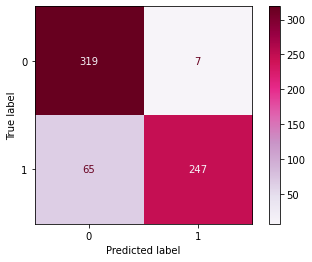

In [40]:
# View confusion matrix
plot_confusion_matrix(gs, X_test, y_test, cmap='PuRd', values_format='d');

Specificity (SP) is calculated as the number of correct negative predictions divided by the total number of negatives. It is also called true negative rate (TNR). The best specificity is 1.0, whereas the worst is 0.0.

In [41]:
# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.9785276073619632


Recall is also known as sensitivity or true positive rate. Recall should ideally be 1 (high) for a good classifier. Recall becomes 1 only when the numerator and denominator are equal i.e TP = TP +FN, this also means FN is zero. As FN increases the value of denominator becomes greater than the numerator and recall value decreases (which we don’t want).

In [42]:
# Calculate the recall

recall_rf = tp / (tp + fn)

print('Recall:', recall_rf)

Recall: 0.7916666666666666


In [43]:
#RandomForest AUC/Accuracy Score
rf_auc_train = gs.score(X_train,y_train)
rf_auc_test = gs.score(X_test,y_test)
rf_acc_train = accuracy_score(gs.predict(X_train),y_train)
rf_acc_test = accuracy_score(gs.predict(X_test),y_test)

In [44]:
print(f'RandomForest AUC train score {rf_auc_train}')
print(f'RandomForest AUC test score {rf_auc_test}')
print(f'RandomForest Accuracy train score {rf_acc_train}')
print(f'RandomForest Accuracy test score {rf_acc_test}')

RandomForest AUC train score 0.9870885892416993
RandomForest AUC test score 0.9767579046720151
RandomForest Accuracy train score 0.905114401076716
RandomForest Accuracy test score 0.8871473354231975


#### Feature Ranking


In [45]:
feature_names = pd.DataFrame(gs.best_estimator_.named_steps.cvec.get_feature_names(), columns=['feature_name'])

In [46]:
feature_names['importance'] = gs.best_estimator_.named_steps.rf.feature_importances_

In [47]:
feature_names

,feature_name,importance
0,able,0.000192
1,absolute,0.000151
2,absolutely,0.000098
3,accord,0.000210
4,acne,0.001370
...,...,...
995,yesterday,0.000084
996,ylang,0.000000
997,youtube,0.000000
998,ysl,0.001188


In [48]:
feature_names.sort_values(by="importance",ascending=False)[:10]

,feature_name,importance
499,look,0.052755
802,smell,0.052458
278,eye,0.050817
326,foundation,0.048673
631,perfume,0.046217
757,scent,0.033975
93,bottle,0.029006
283,eyeshadow,0.027349
284,face,0.026310
174,concealer,0.026024


# Naive Bayes

Naive Bayes is a family of probabilistic algorithms that take advantage of probability theory and Bayes’ Theorem to predict the tag of a text (like a piece of news or a customer review). They are probabilistic, which means that they calculate the probability of each tag for a given text, and then output the tag with the highest one. The way they get these probabilities is by using Bayes’ Theorem, which describes the probability of a feature, based on prior knowledge of conditions that might be related to that feature.

In [49]:
MultinomialNB().get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [50]:
#Creating Pipeline for Naive Bayes Model
pipe2 = Pipeline([("vec", None), ("model", MultinomialNB())])

param_grid2 = {"vec": [CountVectorizer(), TfidfVectorizer()],
              'vec__max_features': [800, 900, 1_000],
              'vec__stop_words': [None, "english"],
              'vec__min_df': [2, 3],
              'vec__max_df': [.9, .95],
              'vec__ngram_range': [(1, 1),(1, 2),(2,3)],     
             }

#gs = GridSearchCV(pipe_tvec, param_grid = pipe_tvec_params, cv=5) 
scorers = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

gs_nb = GridSearchCV(pipe2, param_grid2,cv = 3, scoring = scorers,refit = 'AUC')

In [51]:
start_time = datetime.now()

In [52]:
#Fitting Pipeline into GridSearchCV
gs_nb.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vec', None),
                                       ('model', MultinomialNB())]),
             param_grid={'vec': [CountVectorizer(max_df=0.9, max_features=1000,
                                                 min_df=3,
                                                 stop_words='english'),
                                 TfidfVectorizer()],
                         'vec__max_df': [0.9, 0.95],
                         'vec__max_features': [800, 900, 1000],
                         'vec__min_df': [2, 3],
                         'vec__ngram_range': [(1, 1), (1, 2), (2, 3)],
                         'vec__stop_words': [None, 'english']},
             refit='AUC',
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

In [53]:
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:01:23.151603


In [54]:
#print the best score for CV = 3
print(gs_nb.best_score_)

0.9910869247989872


In [55]:
print(gs_nb.best_score_)

0.9910869247989872


In [56]:
#model score on training set
gs_nb.score(X_train, y_train)

0.9941976584022039

In [57]:
#score model on test set
gs_nb.score(X_test, y_test)

0.9891409076608463

In [58]:
#get the best params
gs_nb.best_params_

{'vec': CountVectorizer(max_df=0.9, max_features=1000, min_df=3, stop_words='english'),
 'vec__max_df': 0.9,
 'vec__max_features': 1000,
 'vec__min_df': 3,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': 'english'}

In [59]:
#get predictions
preds2 = gs_nb.predict(X_test)

#save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds2).ravel()

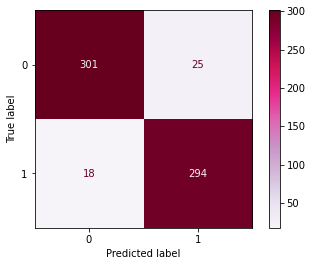

In [60]:
# View confusion matrix
plot_confusion_matrix(gs_nb, X_test, y_test, cmap='PuRd', values_format='d');

Specificity (SP) is calculated as the number of correct negative predictions divided by the total number of negatives. It is also called true negative rate (TNR). The best specificity is 1.0, whereas the worst is 0.0.

In [61]:
# Calculate the specificity

spec_nb = tn / (tn + fp)

print('Specificity:', spec_nb)

Specificity: 0.9233128834355828


Recall is also known as sensitivity or true positive rate. Recall should ideally be 1 (high) for a good classifier. Recall becomes 1 only when the numerator and denominator are equal i.e TP = TP +FN, this also means FN is zero. As FN increases the value of denominator becomes greater than the numerator and recall value decreases (which we don’t want).

In [62]:
# Calculate the recall

recall_nb = tp / (tp + fn)

print('Recall:', recall_nb)

Recall: 0.9423076923076923


In [63]:
# AUC/Accuracy Score
aucnb_train = gs_nb.score(X_train,y_train)
aucnb_test = gs_nb.score(X_test,y_test)
accnb_train = accuracy_score(gs_nb.predict(X_train),y_train)
accnb_test = accuracy_score(gs_nb.predict(X_test),y_test)

In [64]:
print(f'Naive Bayes AUC train score {aucnb_train}')
print(f'Naive Bayes AUC test score {aucnb_test}')
print(f'Naive Bayes Accuracy train score {accnb_train}')
print(f'Naive Bayes Accuracy test score {accnb_test}')

Naive Bayes AUC train score 0.9941976584022039
Naive Bayes AUC test score 0.9891409076608463
Naive Bayes Accuracy train score 0.9535666218034994
Naive Bayes Accuracy test score 0.932601880877743


# Scores 

In [65]:
print(f'Naive Bayes AUC train score {aucnb_train}')
print(f'Naive Bayes AUC test score {aucnb_test}')
print(f'Naive Bayes Accuracy train score {accnb_train}')
print(f'Naive Bayes Accuracy test score {accnb_test}')
print(f'Naive Bayes Specificity {spec_nb}')
print(f'Naive Bayes Recall {recall_nb}')
print('----------------------------------------------')
print('')
print(f'RandomForest AUC train score {rf_auc_train}')
print(f'RandomForest AUC test score {rf_auc_test}')
print(f'RandomForest Accuracy train score {rf_acc_train}')
print(f'RandomForest Accuracy test score {rf_acc_test}')
print(f'RandomForest Specificity {spec}')
print(f'RandomForest Recall {recall_rf}')
print('----------------------------------------------')


Naive Bayes AUC train score 0.9941976584022039
Naive Bayes AUC test score 0.9891409076608463
Naive Bayes Accuracy train score 0.9535666218034994
Naive Bayes Accuracy test score 0.932601880877743
Naive Bayes Specificity 0.9233128834355828
Naive Bayes Recall 0.9423076923076923
----------------------------------------------

RandomForest AUC train score 0.9870885892416993
RandomForest AUC test score 0.9767579046720151
RandomForest Accuracy train score 0.905114401076716
RandomForest Accuracy test score 0.8871473354231975
RandomForest Specificity 0.9785276073619632
RandomForest Recall 0.7916666666666666
----------------------------------------------


In [68]:
print(f'Diff in NB AUC score {aucnb_train - aucnb_test }')
print(f'Diff in NB accuracy score {accnb_train - accnb_test }')
print('----------------------------------------------')
print('')
print(f'Diff in RF AUC score {rf_auc_train - rf_auc_test }')
print(f'Diff in RF accuracy score {rf_acc_train - rf_acc_test }')

Diff in NB AUC score 0.005056750741357585
Diff in NB accuracy score 0.020964740925756398
----------------------------------------------

Diff in RF AUC score 0.010330684569684223
Diff in RF accuracy score 0.017967065653518577


# Conclusion, Recommendation

####  Both models are able to classify which subreddit a post has been given to.
    
           
####  Best model recommendation: Naive Bayes        
     
    * difference between the test/training AUC score and accuracy score is less than 0.01 
    * AUC score and accuracy score is also the highest
    * Lower false negative and false positive
    * Higher Recall(True Positive rate)   
         
         
####  Best Parameters for NB:
'vec': CountVectorizer(max_df=0.9,  
 max_features=1000,   
 min_df=3, stop_words='english'),  
'vec__max_df': 0.9,  
'vec__max_features': 1000,  
'vec__min_df': 3,  
'vec__ngram_range': (1, 1),  
'vec__stop_words': 'english'}   
      
#### Future Steps:
* Explore with other different models
* Select features that are important and see if it can give a better results
* Explore more with hyperparameter tuning
       
    

